# Sentiment Analysis of Tweets with Coronavirus/ Covid19 Hashtags
April Shin

### Focus:
We investigate the sentiment of tweets containing the hashtags *Coronavirus* and/or *Covid19* with and without Asian references.

### Methods:
- Clean dataset by the following:
    - Lowercase text
    - Remove words with backslash x
    - Remove website URLs
    - Removing links, special characters using simple regex statements
    - Remove stopwords
- Compute the polarity and normalized polarity scores of cleaned tweet texts using vader's polarity scores:
    - Polarity score is manually calculated using scores provided in vader's list of scores in vader_lexicon.txt
    - Normalized polarity score is calcuating using SentimentIntensityAnalyzer method from vaderSentiment.vaderSentiment module.
- Identify tweets with Asian reference and if user is a verified user
    - Tweets with any of the keywords such as 'asian', 'asians', 'chinese', 'china', and 'wuhan' are considered to have an Asian reference.
    - We define a 'verified' user to be a user with >= 9000 followers.
- Identify the top five tweets with most negative or positive polarity scores
- Plot the distributions and corresponding means of tweet polarities of various categories:
    - Tweets with and without Asian references
    - Tweets posted by 'verified' users vs 'normal' users

### Resulting DataFrame: 
The result will be stored in DataFrame *tweets_df* with the following columns:
- timestamp
- tweet_text
- username
- all_hashtags
- followers_count
- location
- clean_text
- polarity
- normalized_polarity
- verified_user

In [397]:
#pip install nltk
#pip install vaderSentiment
#pip install geopandas
#pip install descartes

## Import needed files and libraries:

In [401]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from statistics import median, mean
import geopandas as gpd
from shapely.geometry import Point, Polygon

[nltk_data] Downloading package stopwords to /Users/april/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importing vader lexicon 
vader_lex = pd.read_csv('vader_lexicon.txt', 
                   sep='\t',
                   usecols=[0, 1], 
                   names=['token', 'polarity'],
                   index_col='token')

# Setting stopwords
stop_words = list(set(stopwords.words('english')))

In [4]:
# Importing tweets
csv_file = 'hashtagcoronavirus_covid19.csv'
column_name = 'tweet_text'

# Initializing DataFrame tweets_df
tweets_df = pd.read_csv(csv_file)
tweet_text = tweets_df.loc[:, (column_name)]

## Clean data and compute both normalized and non-normalized polarity:

In [5]:
def clean_tweet(tweet): 
    '''
    1. Lowercase text
    2. Remove words with backslash x
    3. Remove website urls
    4. Clean tweet text by removing links, special characters using simple regex statements. 
    5. Remove stopwords
    '''
    
    # 1. Lowercase text
    low = tweet.lower()
    
    # 2. Remove words with backslash x
    low_fil = " ".join(filter(lambda x:x[:2]!='\\x', low.split()))
    
    # 3. Remove website urls
    regexurl = r'http\S+'
    no_urls = low_fil.replace(regexurl, '')

    # 4. Clean tweet text by removing links, special characters using simple regex statements. 
    no_punct = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", no_urls).split())
    
    # 5. Remove stopwords
    cleaned = " ".join(filter(lambda x:x not in stop_words, no_punct.split()))
    
    return cleaned
    

In [6]:
# To compute normalized polarity

def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # object gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [7]:
# Terms that refer to asian ethnic groups
asian_ref = ['asian', 'asians', 'chinese', 'china', 'wuhan', 'asia', 'oriental', 'asiatic', 'eastern']

# Creating new column with cleaned tweet texts
for i in range(len(tweet_text)):
    cleaned = clean_tweet(tweet_text[i][1:])
    tweets_df.at[i, "clean_text"] = cleaned
    
    # Selecting tweets with any reference to asian ethnic groups:
    if (pd.Series(cleaned.split()).isin(asian_ref).any()):
        tweets_df.at[i, "asian_ref"] = 1
    else:
        tweets_df.at[i, "asian_ref"] = 0
        
    # Computing normalized polarity using vader's sentiment_scores function
    tweets_df.at[i, "normalized_polarity"] = sentiment_scores(cleaned)
    
    
# Create column of users' verified status based on follower count
tweets_df['verified_user'] = tweets_df['followers_count'] >= 9000

### Computing non-normalized polarity:

In [8]:
# Converting tweets into tidy_format
tidy_format = (tweets_df["clean_text"].str.split(expand=True).stack().reset_index(level=1).rename(columns={'level_1': 'num', 0: 'word'}))

In [9]:
# Computing polarity of each tweet text by summing polarity of each word in text
# Polarity of each word based on vader's polarity in vader_lexicon.txt 
tweets_df['polarity'] = tidy_format.merge(vader_lex, how='left', left_on='word', right_index=True).reset_index().loc[:, ['index', 'polarity']].groupby('index').sum().fillna(0)

## Result:

### Updated DataFrame Containing All Tweets and Following Information:
timestamp, tweet_text, username, all_hashtags, followers_count, location, clean_text, polarity, normalized_polarity, verified_user

In [10]:
# Updated tweets DataFrame with additional clean_text, polarity, normalized_polarity, and verified_user columns
tweets_df

timestamp                                         tweet_text  \
0    2020-04-14 02:31:35  b'He gets up every day? Hasn\xe2\x80\x99t caug...   
1    2020-04-14 02:31:35  b'@Welptheresthat @NorthmanTrader Not when the...   
2    2020-04-14 02:31:34  b'Holy \xf0\x9f\x92\xa9 \xe2\x81\xa6@VanityFai...   
3    2020-04-14 02:31:32  b'This could be the end of the line for cruise...   
4    2020-04-14 02:31:22  b'Dear @CNN,  Can you sincerely claim @realDon...   
..                   ...                                                ...   
995  2020-04-14 01:34:17  b'@JimWTAE @WTAE And here is a third Smithfiel...   
996  2020-04-14 01:34:15  b'#TruthBeTold  Abso-fucking-lutly!!!  #Heartb...   
997  2020-04-14 01:34:15  b'Trump assembles his crew of X-Men to save us...   
998  2020-04-14 01:34:14  b'A shameful incident of Jaunpur, this is how ...   
999  2020-04-14 01:34:13  b'\xf0\x9f\x94\xa5FACT: CASES NOT DEATHS R HIG...   

               username                                       all_hashtags  \
0      b'bigmusicfan71'     ['coronavirus', 'COVID19', '25thAmendmentNow']   
1             b'GKeeto'  ['china', 'ChinaMustExplain', 'ChinaVirus', 'C...   
2        b'DrumpfsLies'  ['INCOMPETENCEKILLS', 'COVID19', 'coronavirus'...   
3       b'1petermartin'    ['COVID19', 'coronavirus', 'ausecon', 'auspol']   
4         b'WarmMonkey'                         ['coronavirus', 'COVID19']   
..                  ...                                                ...   
995  b'realhumanrights'  ['Wisconsin', 'Cudahy', 'COVID19', 'coronaviru...   
996       b'AltBadDude'  ['TruthBeTold', 'Heartbreaking', 'trumpsameric...   
997   b'BoneKnightmare'  ['EndOfDays', 'apocalypse2020', 'COVID19', 'co...   
998          b'itemads'  ['CoronaVirus', 'CoronaVirusPandemic', 'Corona...   
999    b'SleepyAddicts'  ['coronavirus', 'COVID19', 'WHO', 'CDC', 'viru...   

     followers_count              location  \
0                354                   b''   
1                  6                   b''   
2                230    b'California, USA'   
3              32382                   b''   
4                651  b'Out of The Closet'   
..               ...                   ...   
995             2853      b'Washington DC'   
996             1308      b'Maryland, USA'   
997             3760      b'Parts Unknown'   
998               63             b'Jeddah'   
999             4150            b'Seattle'   

                                            clean_text  asian_ref  \
0    gets every day xe2 x80 x99t caught coronavirus...        0.0   
1    product complete chinese made garbage accounts...        1.0   
2    holy scorchingly amazing incompetencekills cov...        0.0   
3    could end line cruise ships covid19 coronaviru...        0.0   
4    dear sincerely claim handling coronavirus cris...        0.0   
..                                                 ...        ...   
995  third smithfield food plant wisconsin cudahy 2...        0.0   
996  truthbetold abso fucking lutly heartbreaking l...        0.0   
997  trump assembles crew x men save us doomed endo...        0.0   
998  shameful incident jaunpur misuse power happens...        0.0   
999  xf0 x9f x94 xa5fact cases deaths r high 118k d...        0.0   

     normalized_polarity  verified_user  polarity  
0                 0.0000          False       0.0  
1                 0.0000          False       0.0  
2                 0.5859          False       2.8  
3                 0.0000           True       0.0  
4                 0.6584          False       1.3  
..                   ...            ...       ...  
995               0.5574          False       2.6  
996              -0.5829          False      -2.5  
997              -0.2500          False      -1.0  
998              -0.4939          False      -2.2  
999              -0.6124          False      -3.0  

[1000 rows x 11 columns]

## A closer look at the most positive and negative tweets:

### Top 5 Most Positive:

In [11]:
tweets_asian = pd.DataFrame(tweets_df[tweets_df['asian_ref'] == 1.0])
print('Most positive tweets regarding #Coronavirus and #Covid19:')
t = tweets_asian.sort_values(by = ['polarity'], ascending=False)[['polarity', 'tweet_text']].head(5).reset_index()
for i in range(len(t)):
    print('\nPolarity: ', t['polarity'][i], "\nTweet Text: ", t['tweet_text'][i])

Most positive tweets regarding #Coronavirus and #Covid19:

Polarity:  4.7 
Tweet Text:  b'@peterbakernyt #COVID19 #CoronaVirus #Corona #SARSCoV2 #Corona19  \xf0\x9f\x98\xb7   Lol  Approximately 1.4 billion Chinese around the world call it \xe2\x80\x9cWuhan pneumonia\xe2\x80\x9d   \xe6\xad\xa6\xe6\xb1\x89\xe8\x82\xba\xe7\x82\x8e  There\xe2\x80\x99s your Chinese lesson for today.  \xf0\x9f\xa6\xa0'

Polarity:  3.4 
Tweet Text:  b'#Japan offers $2.2B to help domestic companies move production from #China, but will it help the imaging industry? https://t.co/SdNdcPG2TC #Coronavirus #Covid19 #economy'

Polarity:  3.3000000000000003 
Tweet Text:  b'These Asian artists are using their lockdown downtime to create music inspired by the coronavirus.  #COVID19 #coronavirus #lockdown #quarantine'

Polarity:  3.1 
Tweet Text:  b'CORONAVIRUS UPDATE:  STUNNING! US Gave Wuhan Lab $3.7 Million Grant to Study Horseshoe Bats that Carry Coronavirus #COVID19 #COVID2019 #coronavirus #COVID #Covid19usa #Coron

### Top 5 Most Negative

In [12]:
print('Most negative tweets regarding #Coronavirus and #Covid19:')
t = tweets_asian.sort_values(by = ['polarity'], ascending=True)[['polarity', 'tweet_text']].head(5).reset_index()
for i in range(len(t)):
    print('\nPolarity: ', t['polarity'][i], "\nTweet Text: ", t['tweet_text'][i])

Most negative tweets regarding #Coronavirus and #Covid19:

Polarity:  -10.2 
Tweet Text:  b'When Chinese are accusing Taiwanese of racial abuse to Tedros, they are even more racist to people with dark skin. How ironic. #fuckchina #wuhanvirus #chinavirus #ccpvirus #COVID19 #coronavirus #cardib #bitch https://t.co/ntEj8vgCki'

Polarity:  -6.6 
Tweet Text:  b'The death rate in Italy, Spain and France - three of the countries worst-affected by the coronavirus - appears to be slowing.  #coronavirus #CoronaOutbreak #Wuhan #China #COVID19 #India #COVID #CoronaVirusUpdate #ChineseVirus #WuhanVirus #US #Italy #Spain #Germany #France'

Polarity:  -5.2 
Tweet Text:  b'Fighting fake news: The new front in the coronavirus battle @AJENews   #coronavirus  #CoronaOutbreak #Wuhan #China #COVID19 #India #COVID #CoronaVirusUpdate #ChineseVirus #WuhanVirus #US #Italy #Spain #Germany #France #UK #Iran #WHO #FakeNews    https://t.co/Ks4lKhlxsL'

Polarity:  -3.8 
Tweet Text:  b"#Trump claims 'total authority

# Distribution of Tweet Polarities:
Median of all distributions below is equal to 0.

### Distribution of All Tweet Polarities:

In [13]:
max(tweets_df['polarity'])
mean_all = (mean(tweets_df['polarity']))
mean_all

0.1592

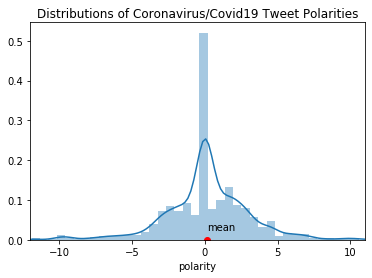

In [14]:
sns.distplot(tweets_df['polarity'])
plt.title('Distributions of Coronavirus/Covid19 Tweet Polarities')
plt.xlim(-12,11)
plt.plot(mean_all, 0, 'ro')
plt.annotate("mean", (mean_all, 0), textcoords="offset points", xytext=(0,10));

### Distribution of Tweet Polarities with Asian References:

In [483]:
# Selecting all tweets with asian reference
asian_ref_tweets = tweets_df.loc[tweets_df['asian_ref'] == 1.0]
mean_asian = (mean(asian_ref_tweets['polarity']))
mean_asian

<class 'pandas.core.frame.DataFrame'>


-0.5194444444444444

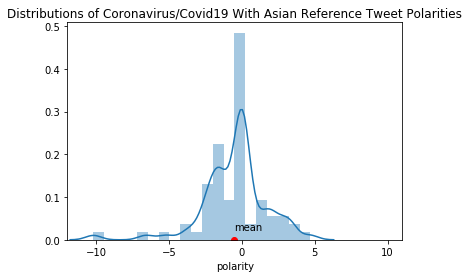

In [16]:
sns.distplot(asian_ref_tweets['polarity'])
plt.title('Distributions of Coronavirus/Covid19 With Asian Reference Tweet Polarities')
plt.xlim(-12,11)
plt.plot(mean_asian, 0, 'ro')
plt.annotate("mean", (mean_asian, 0), textcoords="offset points", xytext=(0,10));

### Combining Distribution of Tweet Polarities With/Without Asian References:

In [17]:
mean_no_asian = mean(tweets_df.loc[tweets_df['asian_ref'] == 0.0]['polarity'])
print("mean_no_asian: ", mean_no_asian)
print("mean_asian: ", mean_asian)

mean_no_asian:  0.21185344827586206
mean_asian:  -0.5194444444444444


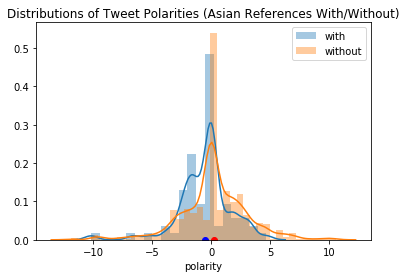

In [18]:
sns.distplot(tweets_df[tweets_df['asian_ref'] == 1.0]['polarity'])
sns.distplot(tweets_df[tweets_df['asian_ref'] == 0.0]['polarity'])
plt.legend(['with', 'without'])
plt.title('Distributions of Tweet Polarities (Asian References With/Without)')
plt.plot(mean_asian, 0, 'bo')
plt.plot(mean_no_asian, 0, 'ro')

In [19]:
asian_ref = tweets_df.loc[tweets_df['asian_ref'] == 1.0]['polarity'] < 0
pos_asian = pd.Series(asian_ref).where(lambda x: x == False).dropna()
neg_asian = pd.Series(asian_ref).where(lambda x: x == True).dropna()
if (len(pos_asian) - len(neg_asian)) < 0:
    asian_sentiment = "Negative"
else:
    asian_sentiment = "Positive"

print(len(pos_asian))
print(len(neg_asian))
print(asian_sentiment)
#sum_asian = sum(tweets_df.loc[tweets_df['asian_ref'] == 1.0]['polarity'])
#print("sum_no_asian: ", sum_no_asian)
#print("sum_asian: ",sum_asian)

#no_asian_ref = tweets_df.loc[tweets_df['asian_ref'] == 0.0]['polarity'] < 0
#neg_no_asian = pd.Series(no_asian_ref).where(lambda x: x == True).dropna()

#print(len(neg_asian))
#print(len(neg_no_asian))

41
31
Positive


### Distribution of Tweet Polarities (Verified Users VS. Normal Users)
Verified users have a high follower count and, consequently, can reach (and may or may not impact) a greater audience than non-verified users (as we call 'normal' users) of Twitter. Therefore, we are interested in comparing the polarity distribution of tweets posted verified users VS. normal users.

Text(0.5, 1.0, 'Distributions of Tweet Polarities (Verified Users vs. Normal Users)')

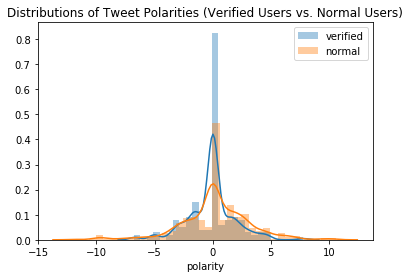

In [62]:
sns.distplot(tweets_df[tweets_df['verified_user'] == True]['polarity'])
sns.distplot(tweets_df[tweets_df['verified_user'] == False]['polarity'])
plt.legend(['verified', 'normal'])
plt.title('Distributions of Tweet Polarities (Verified Users vs. Normal Users)')

# Analysis in progress:

### Importing coronavirus case counts for each US state:

In [489]:
state_virus_counts = pd.read_csv('us_states_virus_count.csv', 
                   sep=',',
                   names=['date', 'state','fips','cases','deaths'])
state_virus_counts['cases'] = list((state_virus_counts['cases']))

for i in range(len(state_virus_counts['cases'])-1):
    i+=1
    state_virus_counts.at[i, 'cases'] = int(state_virus_counts['cases'][i])
virus_counts = state_virus_counts[state_virus_counts['date']=="2020-04-14"].drop_duplicates()
virus_counts.head()

date           state fips cases deaths
2330  2020-04-14         Alabama   01  3953    114
2331  2020-04-14          Alaska   02   283      7
2332  2020-04-14  American Samoa   60     0      0
2333  2020-04-14         Arizona   04  3806    131
2334  2020-04-14        Arkansas   05  1498     32

### Organizing all cities, counties, and states of US:

In [260]:
us_states_counties = pd.read_csv('us_cities_states_counties_data.csv', 
                   sep='\t',
                   usecols=[0], 
                   names=['data'])

In [261]:
for i in range(len(us_states_counties['data'])):
    split_list = us_states_counties['data'][i].split(',')
    
    us_states_counties.at[i, "City"] = split_list[0]
    us_states_counties.at[i, "State_short"] = split_list[1]
    us_states_counties.at[i, "State_full"] = split_list[2]
    us_states_counties.at[i, "County"] = split_list[3]
    us_states_counties.at[i, "City_alias"] = split_list[4]
    us_states_counties.at[i, "lower_city"] = split_list[0].lower()
    us_states_counties.at[i, "lower_state_short"] = split_list[1].lower()
    us_states_counties.at[i, "lower_state_full"] = split_list[2].lower()
    us_states_counties.at[i, "lower_county"] = split_list[3].lower()
    us_states_counties.at[i, "lower_city_alias"] = split_list[4].lower()
    
    #split_list.extend([split_list[0].lower(), split_list[1].lower(), split_list[2].lower(), split_list[3].lower(), split_list[4].lower()])
    #us_states_counties.at[i, "state_county_list"] = split_list
    
us_states_counties

data         City  \
0          City,State_short,State full,County,City alias         City   
1      Holtsville,NY,New York,SUFFOLK,Internal Revenu...   Holtsville   
2              Holtsville,NY,New York,SUFFOLK,Holtsville   Holtsville   
3                 Agawam,MA,Massachusetts,HAMPDEN,Agawam       Agawam   
4             Amherst,MA,Massachusetts,HAMPSHIRE,Amherst      Amherst   
...                                                  ...          ...   
60512    Klawock,AK,Alaska,PRINCE OF WALES HYDER,Klawock      Klawock   
60513  Metlakatla,AK,Alaska,PRINCE OF WALES HYDER,Met...   Metlakatla   
60514  Point Baker,AK,Alaska,PRINCE OF WALES HYDER,Po...  Point Baker   
60515    Ward Cove,AK,Alaska,KETCHIKAN GATEWAY,Ward Cove    Ward Cove   
60516               Wrangell,AK,Alaska,WRANGELL,Wrangell     Wrangell   

       State_short     State_full                 County  \
0      State_short     State full                 County   
1               NY       New York                SUFFOLK   
2               NY       New York                SUFFOLK   
3               MA  Massachusetts                HAMPDEN   
4               MA  Massachusetts              HAMPSHIRE   
...            ...            ...                    ...   
60512           AK         Alaska  PRINCE OF WALES HYDER   
60513           AK         Alaska  PRINCE OF WALES HYDER   
60514           AK         Alaska  PRINCE OF WALES HYDER   
60515           AK         Alaska      KETCHIKAN GATEWAY   
60516           AK         Alaska               WRANGELL   

                     City_alias   lower_city lower_state_short  \
0                    City alias         city       state_short   
1      Internal Revenue Service   holtsville                ny   
2                    Holtsville   holtsville                ny   
3                        Agawam       agawam                ma   
4                       Amherst      amherst                ma   
...                         ...          ...               ...   
60512                   Klawock      klawock                ak   
60513                Metlakatla   metlakatla                ak   
60514               Point Baker  point baker                ak   
60515                 Ward Cove    ward cove                ak   
60516                  Wrangell     wrangell                ak   

      lower_state_full           lower_county          lower_city_alias  
0           state full                 county                city alias  
1             new york                suffolk  internal revenue service  
2             new york                suffolk                holtsville  
3        massachusetts                hampden                    agawam  
4        massachusetts              hampshire                   amherst  
...                ...                    ...                       ...  
60512           alaska  prince of wales hyder                   klawock  
60513           alaska  prince of wales hyder                metlakatla  
60514           alaska  prince of wales hyder               point baker  
60515           alaska      ketchikan gateway                 ward cove  
60516           alaska               wrangell                  wrangell  

[60517 rows x 11 columns]

### Using major city names and states to determine the location of each tweet:

In [377]:
major_cities = pd.read_csv('city_names.txt', 
                   sep='\t',
                   usecols=[0], 
                   names=['City'])

#### Analyzing Tweets with Asian references:

In [485]:

loc = asian_ref_tweets.groupby('location')[['location', 'polarity']].first()['location']
pol = asian_ref_tweets.groupby('location')[['location', 'polarity']].first()['polarity']
dict = {'loc':loc, 'polarity':pol}
loc_pol_asian_ref = pd.DataFrame(dict).reset_index()[['loc','polarity']]

cities_states = major_cities.merge(us_states_counties, how='left')
cities_states.drop(['County', 'lower_county', 'City_alias', 'lower_city_alias', 'data'], axis=1).drop_duplicates()
states_df = cities_states[['State_short', 'State_full','City','lower_state_short', 'lower_state_full','lower_city']].drop_duplicates().reset_index()

for i in range(len(loc_pol_asian_ref)):
    cleaned = clean_tweet(loc_pol_asian_ref['loc'][i][1:])
    loc_pol.at[i, "clean_loc"] = cleaned
    cleaned_split = pd.Series(cleaned.split())

    for j in range(len(states_df)):
        states_list = list(states_df.loc[j])
        #states_list.extend(['USA','usa'])        
        
        if (cleaned_split.isin(states_list).any()):
            loc_pol_asian_ref.at[i, "us_location"] = states_list[1:]
            loc_pol_asian_ref.at[i, "is_it_us_state"] = 1
            break
        else:
            loc_pol_asian_ref.at[i, "us_location"] = ["None"]
            loc_pol_asian_ref.at[i, "is_it_us_state"] = 0

In [487]:

us_loc_asian_ref = (loc_pol_asian_ref[loc_pol_asian_ref['is_it_us_state'] == 1.0]).reset_index()
us_loc_asian_ref

index                               loc  polarity  \
0       2                         b'Alaska'      -2.2   
1       4                b'Ashland, Oregon'       0.0   
2       9  b'California, USA ~ District 43'      -1.8   
3      10                  b'Columbus Ohio'      -1.3   
4      12                  b'Henderson, KY'       0.0   
5      13                    b'Houston, TX'      -1.4   
6      14                 b'Louisville, KY'       3.1   
7      15                  b'Milwaukee, WI'       0.0   
8      17                  b'New York, USA'      -1.7   
9      18                    b'Phoenix, AZ'      -0.9   
10     19  b'Pittsburgh, Pennsylvania, USA'       0.0   
11     20                    b'Roxbury, NJ'      -1.8   
12     21                    b'Seattle, WA'       2.2   
13     22             b'Sonoma, California'       0.0   
14     26                   b'Trumbull, CT'      -1.6   

                                          us_location  is_it_us_state  
0      [AK, Alaska, Anchorage, ak, alaska, anchorage]             1.0  
1            [OR, Oregon, Albany, or, oregon, albany]             1.0  
2    [CA, California, Albany, ca, california, albany]             1.0  
3            [OH, Ohio, Aberdeen, oh, ohio, aberdeen]             1.0  
4    [KY, Kentucky, Aberdeen, ky, kentucky, aberdeen]             1.0  
5            [TX, Texas, Abilene, tx, texas, abilene]             1.0  
6    [KY, Kentucky, Aberdeen, ky, kentucky, aberdeen]             1.0  
7      [WI, Wisconsin, Albany, wi, wisconsin, albany]             1.0  
8                  [ME, Maine, York, me, maine, york]             1.0  
9    [AZ, Arizona, Arlington, az, arizona, arlington]             1.0  
10  [PA, Pennsylvania, Akron, pa, pennsylvania, ak...             1.0  
11  [NJ, New Jersey, Allentown, nj, new jersey, al...             1.0  
12  [WA, Washington, Aberdeen, wa, washington, abe...             1.0  
13   [CA, California, Albany, ca, california, albany]             1.0  
14  [CT, Connecticut, Bethlehem, ct, connecticut, ...             1.0

#### Analyzing All Tweets:

In [327]:
loc = tweets_df.groupby('location')[['location', 'polarity']].first()['location']
pol = tweets_df.groupby('location')[['location', 'polarity']].first()['polarity']
dict = {'loc':loc, 'polarity':pol}
loc_pol = pd.DataFrame(dict).reset_index()[['loc','polarity']]

cities_states = major_cities.merge(us_states_counties, how='left')
cities_states.drop(['County', 'lower_county', 'City_alias', 'lower_city_alias', 'data'], axis=1).drop_duplicates()
states_df = cities_states[['State_short', 'State_full','City','lower_state_short', 'lower_state_full','lower_city']].drop_duplicates().reset_index()

for i in range(len(loc_pol)):
    cleaned = clean_tweet(loc_pol['loc'][i][1:])
    loc_pol.at[i, "clean_loc"] = cleaned
    cleaned_split = pd.Series(cleaned.split())

    for j in range(len(states_df)):
        states_list = list(states_df.loc[j])
        #states_list.extend(['USA','usa'])        
        
        if (cleaned_split.isin(states_list).any()):
            loc_pol.at[i, "us_location"] = states_list[1:]
            loc_pol.at[i, "is_it_us_state"] = 1
            break
        else:
            loc_pol.at[i, "us_location"] = ["None"]
            loc_pol.at[i, "is_it_us_state"] = 0

In [384]:
loc_pol

loc  polarity                    clean_loc  \
0               b"California dreamin'"      -2.6           california dreamin   
1      b"Warning: I don't follow back"      -0.2          warning follow back   
2                              b' USA'       4.2                          usa   
3    b'#RadicalFreeSpeech + Democracy'       3.2  radicalfreespeech democracy   
4         b'#RemoteWork #Boston #NYC '       0.7        remotework boston nyc   
..                                 ...       ...                          ...   
430                             b'nyc'      -3.1                          nyc   
431                        b'oklahoma'       0.8                     oklahoma   
432                          b'online'       2.5                       online   
433                    b'planet earth'      -9.0                 planet earth   
434    b'somewhere in the western usa'      -1.1        somewhere western usa   

                                           us_location  is_it_us_state  \
0     [CA, California, Albany, ca, california, albany]             1.0   
1                                               [None]             0.0   
2                                               [None]             0.0   
3                                               [None]             0.0   
4    [MA, Massachusetts, Boston, ma, massachusetts,...             1.0   
..                                                 ...             ...   
430                                             [None]             0.0   
431       [OK, Oklahoma, Albany, ok, oklahoma, albany]             1.0   
432                                             [None]             0.0   
433                                             [None]             0.0   
434                                             [None]             0.0   

          state  
0    California  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
430         NaN  
431         NaN  
432         NaN  
433         NaN  
434         NaN  

[435 rows x 6 columns]

In [374]:
us_loc = (loc_pol[loc_pol['is_it_us_state'] == 1.0]).reset_index()
for i in range(len(us_loc)):
    us_loc.at[i, "state"] = us_loc['us_location'][i][1]

date                     state fips   cases deaths
2330  2020-04-14                   Alabama   01    3953    114
2331  2020-04-14                    Alaska   02     283      7
2332  2020-04-14            American Samoa   60       0      0
2333  2020-04-14                   Arizona   04    3806    131
2334  2020-04-14                  Arkansas   05    1498     32
2335  2020-04-14                California   06   25758    778
2336  2020-04-14                  Colorado   08    7941    329
2337  2020-04-14               Connecticut   09   13989    671
2338  2020-04-14                  Delaware   10    1926     43
2339  2020-04-14      District of Columbia   11    2058     67
2340  2020-04-14                   Florida   12   21620    570
2341  2020-04-14                   Georgia   13   13913    517
2342  2020-04-14                      Guam   66     721      6
2343  2020-04-14                    Hawaii   15     511      9
2344  2020-04-14                     Idaho   16    1464     39
2345  2020-04-14                  Illinois   17   23247    878
2346  2020-04-14                   Indiana   18    8527    387
2347  2020-04-14                      Iowa   19    1899     44
2348  2020-04-14                    Kansas   20    1439     69
2349  2020-04-14                  Kentucky   21    2210    115
2350  2020-04-14                 Louisiana   22   21518   1013
2351  2020-04-14                     Maine   23     734     20
2352  2020-04-14                  Maryland   24    9472    302
2353  2020-04-14             Massachusetts   25   28163    957
2354  2020-04-14                  Michigan   26   26844   1766
2355  2020-04-14                 Minnesota   27    1695     79
2356  2020-04-14               Mississippi   28    3087    111
2357  2020-04-14                  Missouri   29    4686    152
2358  2020-04-14                   Montana   30     399      7
2359  2020-04-14                  Nebraska   31     931     21
2360  2020-04-14                    Nevada   32    3137    130
2361  2020-04-14             New Hampshire   33    1091     27
2362  2020-04-14                New Jersey   34   68824   2805
2363  2020-04-14                New Mexico   35    1407     36
2364  2020-04-14                  New York   36  202208  10834
2365  2020-04-14            North Carolina   37    5024    116
2366  2020-04-14              North Dakota   38     341      9
2367  2020-04-14  Northern Mariana Islands   69      13      2
2368  2020-04-14                      Ohio   39    7280    324
2369  2020-04-14                  Oklahoma   40    2184    109
2370  2020-04-14                    Oregon   41    1633     55
2371  2020-04-14              Pennsylvania   42   25591    746
2372  2020-04-14               Puerto Rico   72     923     45
2373  2020-04-14              Rhode Island   44    3251     80
2374  2020-04-14            South Carolina   45    3553     97
2375  2020-04-14              South Dakota   46     988      6
2376  2020-04-14                 Tennessee   47    5654    123
2377  2020-04-14                     Texas   48   15304    365
2378  2020-04-14                      Utah   49    2418     19
2379  2020-04-14                   Vermont   50     752     29
2380  2020-04-14            Virgin Islands   78      51      1
2381  2020-04-14                  Virginia   51    6171    154
2382  2020-04-14                Washington   53   10694    552
2383  2020-04-14             West Virginia   54     697     10
2384  2020-04-14                 Wisconsin   55    3555    172
2385  2020-04-14                   Wyoming   56     282      1

In [470]:
us_loc_virus = us_loc.merge(virus_counts, left_on="state", right_on="state")

In [476]:
mean_pol_cases = us_loc_virus.groupby(['state', 'cases'], as_index=False).mean().reset_index().drop(['level_0', 'is_it_us_state', 'index'], axis=1).rename(columns={'state':'STATE_NAME', 'polarity':'mean_polarity'})
mean_pol_cases.sort_values(by=['cases'], ascending=False)

STATE_NAME   cases  mean_polarity
26        New York  202208       0.595455
25      New Jersey   68824      -0.450000
17   Massachusetts   28163       0.950000
18        Michigan   26844       0.800000
3       California   25758       0.703448
31    Pennsylvania   25591       0.570000
10        Illinois   23247       0.281818
6          Florida   21620       1.176471
14       Louisiana   21518       0.000000
34           Texas   15304       1.106667
5      Connecticut   13989      -0.375000
7          Georgia   13913      -0.111111
36      Washington   10694       0.006667
16        Maryland    9472      -2.800000
11         Indiana    8527      -5.600000
4         Colorado    7941       0.400000
28            Ohio    7280      -0.475000
35        Virginia    6171       1.025000
33       Tennessee    5654       3.140000
27  North Carolina    5024      -0.900000
21        Missouri    4686      -0.233333
0          Alabama    3953       2.540000
2          Arizona    3806      -1.600000
38       Wisconsin    3555       3.366667
32  South Carolina    3553       1.350000
24          Nevada    3137       0.500000
20     Mississippi    3087      -0.600000
13        Kentucky    2210       0.775000
29        Oklahoma    2184      -0.240000
19       Minnesota    1695       4.700000
30          Oregon    1633       0.550000
9            Idaho    1464      -1.600000
12          Kansas    1439       2.200000
23        Nebraska     931      -1.100000
15           Maine     734       0.177778
37   West Virginia     697      -0.600000
8           Hawaii     511      -1.200000
22         Montana     399      -2.900000
1           Alaska     283      -2.200000
39         Wyoming     282       0.000000

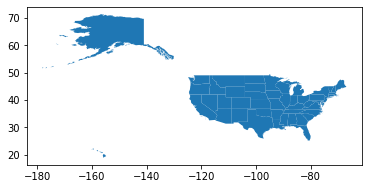

In [406]:
usa = gpd.read_file('./states_21basic/states.shp')
usa.plot()

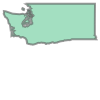

In [408]:
usa.loc[1,'geometry']

In [490]:
usa.head()

STATE_NAME  DRAWSEQ STATE_FIPS          SUB_REGION STATE_ABBR  \
0        Hawaii        1         15             Pacific         HI   
1    Washington        2         53             Pacific         WA   
2       Montana        3         30            Mountain         MT   
3         Maine        4         23         New England         ME   
4  North Dakota        5         38  West North Central         ND   

                                            geometry  
0  MULTIPOLYGON (((-160.07380 22.00418, -160.0497...  
1  MULTIPOLYGON (((-122.40202 48.22522, -122.4628...  
2  POLYGON ((-111.47543 44.70216, -111.48080 44.6...  
3  MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...  
4  POLYGON ((-98.73044 45.93827, -99.00683 45.939...

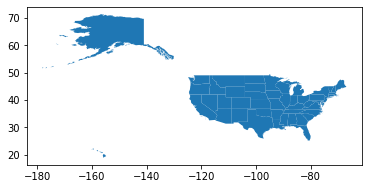

In [472]:
usa_polarities = usa.merge(mean_pol_cases, how='left')
usa_polarities.plot()

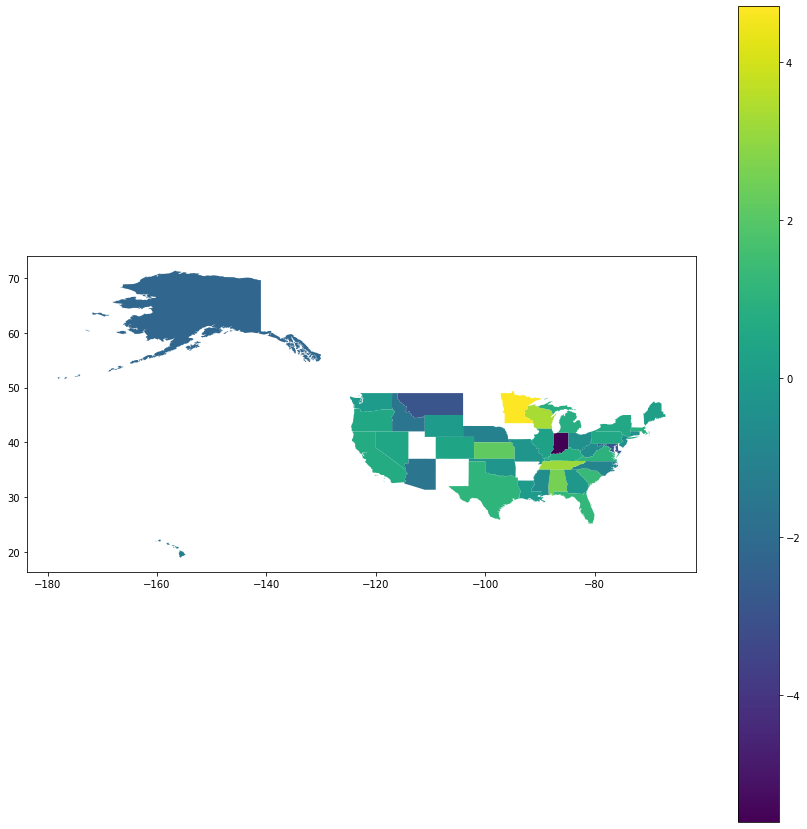

In [473]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
usa_polarities.dropna().plot(column='mean_polarity',ax=ax, legend=True)

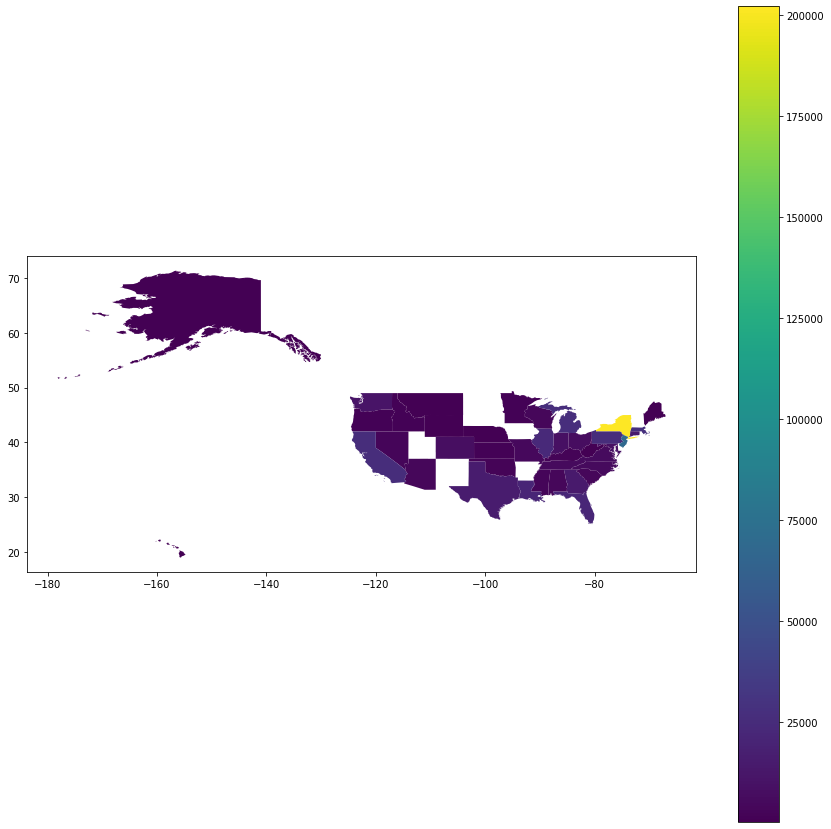

In [474]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
usa_polarities.dropna().plot(column='cases',ax=ax, legend=True)
#plt.colorbar(label='Coronavirus Cases Count')